In [ ]:
__author__ = "Jithin Pradeep"
__copyright__ = "Copyright (C) 2018 Jithin Pradeep"
__license__ = "MIT License"
__version__ = "1.0"

# Summary 

## About the Dataset
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

Visually, the pixels make up the image like this:

000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 

The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

[More about MNIST Dataset can be found here](http://yann.lecun.com/exdb/mnist/)
[Wiki Link](https://en.wikipedia.org/wiki/MNIST_database)

## Method

In this post I will be describing my solution to classify handwritten digits(MNIST Dataset). Below is a deep neural network(Convolution neural network) consisting of convolution and fully connected layers.
![Model image](png.PNG)

Go ahead and use the tensorboard for deatiled visualization saved from the model.


In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline

import platform
print("Platform deatils {0} \nPython version {1}".format(
    platform.platform(), platform.python_version()))

Platform deatils Windows-10-10.0.15063-SP0 
Python version 3.6.2


Using TensorFlow backend.


Additional info: I am going to use the Kaggle csv based data set but MNIST Data set can also be downloaded and extracted using the below functions. 

#### Function to downlaod and Extract MNIST Dataset 

In [ ]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

In [ ]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

In [47]:
#Load the input file from the folder

if os.path.isfile('MNISTdatacsv/train.csv'):
    data_df = pd.read_csv('MNISTdatacsv/train.csv') 
    print('train.csv loaded: data_df({0[0]},{0[1]})'.format(data_df.shape))
else:
    print('Error: train.csv not found')
    
## read test data

# read test data from CSV file 
if os.path.isfile('MNISTdatacsv/test.csv'):
    test_df = pd.read_csv('MNISTdatacsv/test.csv') 
    print('test.csv loaded: test_df{0}'.format(test_df.shape))
else:
    print('Error: test.csv not found')
    
# transforma and normalize test data
x_test = test_df.iloc[:,0:].values.reshape(-1,28,28,1) # (28000,28,28,1) array
x_test = x_test.astype(np.float)
x_test = normalize_data(x_test)
print('x_test.shape = ', x_test.shape)

# for saving results
y_test_pred = {}
y_test_pred_labels = {}

train.csv loaded: data_df(42000,785)
test.csv loaded: test_df(28000, 784)
x_test.shape =  (28000, 28, 28, 1)


### Preprocessing

#### Normalize data and split into training and validation sets
- In order to scale feature that robust to outlier you can use sklearn.preprocessing.RobustScaler()
        - rtoo = sklearn.preprocessing.RobustScaler()
        - rtoo.fit(data)
        - data = rtoo.transform(data) 
- or you can do standraization by using mean and std dev
        - data = (data-data.mean())/(data.std()) (Try different normalization techniques 
        - to understand more about normalization, these are just few) 
- Another idea might be is to convert the rgb range to -1 to 1 from 255 to 0
        - data = ((data / 255.)-0.5)*2.
        - I am converting the range to 0 to 1
        
[One hot encoding my notes](http://jp.jithinjp.in/2018/Representing-Categorical-values-in-Machine-learning)        

x_train_valid.shape =  (42000, 28, 28, 1)
y_train_valid_labels.shape =  (42000,)
image_size =  784
image_width =  28
image_height =  28
labels_count =  10


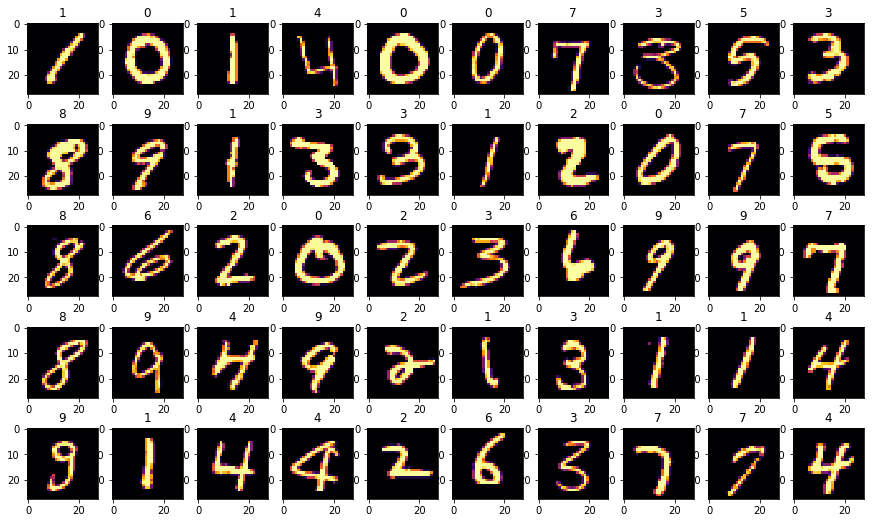

In [66]:
# function to normalize data
def normalize_data(data): 
    data = data / data.max() # convert from [0:255] to [0.:1.]    
    return data

# class labels to one-hot vectors e.g. 1 => [0 1 0 0 0 0 0 0 0 0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# one-hot encodings into labels
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot,1)

# accuracy o
def accuracy_from_dense_labels(y_target, y_pred):
    y_target = y_target.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    return np.mean(y_target == y_pred)

# accuracy of one-hot encoded predictions
def accuracy_from_one_hot_labels(y_target, y_pred):
    y_target = one_hot_to_dense(y_target).reshape(-1,)
    y_pred = one_hot_to_dense(y_pred).reshape(-1,)
    return np.mean(y_target == y_pred)

# extract and normalize images
x_train_valid = data_df.iloc[:,1:].values.reshape(-1,28,28,1) # (42000,28,28,1) array
x_train_valid = x_train_valid.astype(np.float) # convert from int64 to float32
x_train_valid = normalize_data(x_train_valid)
image_width = image_height = 28
image_size = 784

# extract image labels
y_train_valid_labels = data_df.iloc[:,0].values # (42000,1) array
labels_count = np.unique(y_train_valid_labels).shape[0]; # number of different labels = 10

#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.title(y_train_valid_labels[i])
    plt.imshow(x_train_valid[i].reshape(28,28), cmap=cm.inferno)
    
# labels in one hot representation
y_train_valid = dense_to_one_hot(y_train_valid_labels, labels_count).astype(np.uint8)

# dictionaries for saving results
y_valid_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}

print('x_train_valid.shape = ', x_train_valid.shape)
print('y_train_valid_labels.shape = ', y_train_valid_labels.shape)
print('image_size = ', image_size )
print('image_width = ', image_width)
print('image_height = ', image_height)
print('labels_count = ', labels_count)

#### Data augmenttaion
lets stick to basics like rotations, translations, zoom using keras 

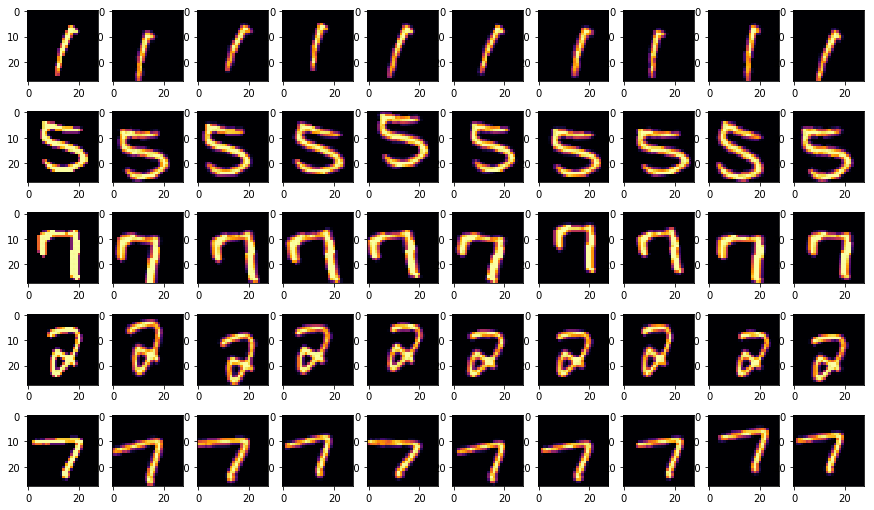

In [58]:
def generate_images(imgs):    
    # rotations, translations, zoom
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        zoom_range = 0.1)

    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()    
  
    return imgs[0]

# Visulizing the image augmnettaion
fig,axs = plt.subplots(5,10, figsize=(15,9))
for i in range(5):
    n = np.random.randint(0,x_train_valid.shape[0]-2)
    axs[i,0].imshow(x_train_valid[n:n+1].reshape(28,28),cmap=cm.inferno)
    for j in range(1,10):
        axs[i,j].imshow(generate_images(x_train_valid[n:n+1]).reshape(28,28), cmap=cm.inferno)


### Benchmarking on some basic ML models
As we have our training data ready lets run couple of basic machine elarning model, I would consider these models to  kind of create a baseline which would help me later own to generlize the performance of my model. In simple word these would give me datapoints to compare the performance across models.

lets use Logistic regression, Extra tress regressor and Random forest model along with cross validation for benmarking.

In [30]:
logistic_regression = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs',multi_class='multinomial')
extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose=0)
random_forest = sklearn.ensemble.RandomForestClassifier(verbose=0)

bench_markingDict = {'logistic_regression': logistic_regression, 
                 'extra_trees': extra_trees,
                 'random_forest': random_forest }
        
bench_marking = ['logistic_regression', 'extra_trees','random_forest']        
for bm_model in bench_marking:
    train_acc[bm_model] = []
    valid_acc[bm_model] = []

cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):

    # start timer
    start = datetime.datetime.now();

    # train and validation data of original images
    x_train = x_train_valid[train_index].reshape(-1,784)
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index].reshape(-1,784)
    y_valid = y_train_valid[valid_index]

    for bm_model in bench_marking:

        # create cloned model from base models
        model = sklearn.base.clone(bench_markingDict[bm_model])
        model.fit(x_train, one_hot_to_dense(y_train))

        # predictions
        y_train_pred[bm_model] = model.predict_proba(x_train)
        y_valid_pred[bm_model] = model.predict_proba(x_valid)
        train_acc[bm_model].append(accuracy_from_one_hot_labels(y_train_pred[bm_model], y_train))
        valid_acc[bm_model].append(accuracy_from_one_hot_labels(y_valid_pred[bm_model], y_valid))

        print(i+1,': '+bm_model+' train/valid accuracy = %.3f/%.3f'%(train_acc[bm_model][-1], 
                                                             valid_acc[bm_model][-1]))
    # only one iteration
    if False:
        break;

print(bm_model+': averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[bm_model]),
                                                        np.mean(valid_acc[bm_model])))



1 : logistic_regression train/valid accuracy = 0.940/0.920
1 : extra_trees train/valid accuracy = 1.000/0.947
1 : random_forest train/valid accuracy = 0.999/0.941
2 : logistic_regression train/valid accuracy = 0.940/0.922
2 : extra_trees train/valid accuracy = 1.000/0.949
2 : random_forest train/valid accuracy = 0.999/0.941
3 : logistic_regression train/valid accuracy = 0.939/0.928
3 : extra_trees train/valid accuracy = 1.000/0.944
3 : random_forest train/valid accuracy = 0.999/0.945
4 : logistic_regression train/valid accuracy = 0.939/0.924
4 : extra_trees train/valid accuracy = 1.000/0.945
4 : random_forest train/valid accuracy = 0.999/0.941
5 : logistic_regression train/valid accuracy = 0.940/0.920
5 : extra_trees train/valid accuracy = 1.000/0.939
5 : random_forest train/valid accuracy = 0.999/0.941
6 : logistic_regression train/valid accuracy = 0.939/0.919
6 : extra_trees train/valid accuracy = 1.000/0.948
6 : random_forest train/valid accuracy = 0.999/0.941
7 : logistic_regressio

### Neural network -
Lets get to the fun part Neural network

In [38]:
class nn_class:
# class that implements the neural network

    # constructor
    def __init__(self, nn_name = 'nn_1'):

        #  hyperparameters 
        self.s_f_conv1 = 3; # filter size of first convolution layer (default = 3)
        self.n_f_conv1 = 36; # number of features of first convolution layer (default = 36)
        self.s_f_conv2 = 3; # filter size of second convolution layer (default = 3)
        self.n_f_conv2 = 36; # number of features of second convolution layer (default = 36)
        self.s_f_conv3 = 3; # filter size of third convolution layer (default = 3)
        self.n_f_conv3 = 36; # number of features of third convolution layer (default = 36)
        self.n_n_fc1 = 576; # number of neurons of first fully connected layer (default = 576)

        # hyperparameters for training
        self.mb_size = 50 # mini batch size
        self.keep_prob = 0.33 # keeping probability with dropout regularization 
        self.learn_rate_array = [10*1e-4, 7.5*1e-4, 5*1e-4, 2.5*1e-4, 1*1e-4, 1*1e-4,
                                 1*1e-4,0.75*1e-4, 0.5*1e-4, 0.25*1e-4, 0.1*1e-4, 
                                 0.1*1e-4, 0.075*1e-4,0.050*1e-4, 0.025*1e-4, 0.01*1e-4, 
                                 0.0075*1e-4, 0.0050*1e-4,0.0025*1e-4,0.001*1e-4]
        self.learn_rate_step_size = 3 # in terms of epochs
        
        # parameters
        self.learn_rate = self.learn_rate_array[0]
        self.learn_rate_pos = 0 # current position pointing to current learning rate
        self.index_in_epoch = 0 
        self.current_epoch = 0
        self.log_step = 0.2 # log results in terms of epochs
        self.n_log_step = 0 # counting current number of mini batches trained on
        self.use_tb_summary = False # True = use tensorboard visualization
        self.use_tf_saver = False # True = use saver to save the model
        self.nn_name = nn_name # name of the neural network
        
        # permutation array
        self.perm_array = np.array([])
        
    # get the next mini batch
    def next_mini_batch(self):

        start = self.index_in_epoch
        self.index_in_epoch += self.mb_size
        self.current_epoch += self.mb_size/len(self.x_train)  
        
        # adapt length of permutation array
        if not len(self.perm_array) == len(self.x_train):
            self.perm_array = np.arange(len(self.x_train))
        
        # shuffle once at the start of epoch
        if start == 0:
            np.random.shuffle(self.perm_array)

        # at the end of the epoch
        if self.index_in_epoch > self.x_train.shape[0]:
            np.random.shuffle(self.perm_array) # shuffle data
            start = 0 # start next epoch
            self.index_in_epoch = self.mb_size # set index to mini batch size
            
            if self.train_on_augmented_data:
                # use augmented data for the next epoch
                self.x_train_aug = normalize_data(self.generate_images(self.x_train))
                self.y_train_aug = self.y_train
                
        end = self.index_in_epoch
        
        if self.train_on_augmented_data:
            # use augmented data
            x_tr = self.x_train_aug[self.perm_array[start:end]]
            y_tr = self.y_train_aug[self.perm_array[start:end]]
        else:
            # use original data
            x_tr = self.x_train[self.perm_array[start:end]]
            y_tr = self.y_train[self.perm_array[start:end]]
        
        return x_tr, y_tr
               
    # generate new images via rotations, translations, zoom using keras
    def generate_images(self, imgs):
    
        print('generate new set of images')
        
        # rotations, translations, zoom
        image_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
            zoom_range = 0.1)

        # get transformed images
        imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                    batch_size=len(imgs), shuffle = False).next()    

        return imgs[0]

    # weight initialization
    def weight_variable(self, shape, name = None):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name = name)

    # bias initialization
    def bias_variable(self, shape, name = None):
        initial = tf.constant(0.1, shape=shape) #  positive bias
        return tf.Variable(initial, name = name)

    # 2D convolution
    def conv2d(self, x, W, name = None):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name = name)

    # max pooling
    def max_pool_2x2(self, x, name = None):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME', name = name)

    # attach summaries to a tensor for TensorBoard visualization
    def summary_variable(self, var, var_name):
        with tf.name_scope(var_name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('mean', mean)
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)
    
    # function to create the graph
    def create_graph(self):

        # reset default graph
        tf.reset_default_graph()

        # variables for input and output 
        self.x_data_tf = tf.placeholder(dtype=tf.float32, shape=[None,28,28,1], 
                                        name='x_data_tf')
        self.y_data_tf = tf.placeholder(dtype=tf.float32, shape=[None,10], name='y_data_tf')

        # 1.layer: convolution + max pooling
        self.W_conv1_tf = self.weight_variable([self.s_f_conv1, self.s_f_conv1, 1,
                                                self.n_f_conv1], 
                                               name = 'W_conv1_tf') # (5,5,1,32)
        self.b_conv1_tf = self.bias_variable([self.n_f_conv1], name = 'b_conv1_tf') # (32)
        self.h_conv1_tf = tf.nn.relu(self.conv2d(self.x_data_tf, 
                                                 self.W_conv1_tf) + self.b_conv1_tf, 
                                     name = 'h_conv1_tf') # (.,28,28,32)
        self.h_pool1_tf = self.max_pool_2x2(self.h_conv1_tf, 
                                            name = 'h_pool1_tf') # (.,14,14,32)

        # 2.layer: convolution + max pooling
        self.W_conv2_tf = self.weight_variable([self.s_f_conv2, self.s_f_conv2, 
                                                self.n_f_conv1, self.n_f_conv2], 
                                               name = 'W_conv2_tf')
        self.b_conv2_tf = self.bias_variable([self.n_f_conv2], name = 'b_conv2_tf')
        self.h_conv2_tf = tf.nn.relu(self.conv2d(self.h_pool1_tf, 
                                                 self.W_conv2_tf) + self.b_conv2_tf, 
                                     name ='h_conv2_tf') #(.,14,14,32)
        self.h_pool2_tf = self.max_pool_2x2(self.h_conv2_tf, name = 'h_pool2_tf') #(.,7,7,32)

        # 3.layer: convolution + max pooling
        self.W_conv3_tf = self.weight_variable([self.s_f_conv3, self.s_f_conv3, 
                                                self.n_f_conv2, self.n_f_conv3], 
                                               name = 'W_conv3_tf')
        self.b_conv3_tf = self.bias_variable([self.n_f_conv3], name = 'b_conv3_tf')
        self.h_conv3_tf = tf.nn.relu(self.conv2d(self.h_pool2_tf, 
                                                 self.W_conv3_tf) + self.b_conv3_tf, 
                                     name = 'h_conv3_tf') #(.,7,7,32)
        self.h_pool3_tf = self.max_pool_2x2(self.h_conv3_tf, 
                                            name = 'h_pool3_tf') # (.,4,4,32)

        # 4.layer: fully connected
        self.W_fc1_tf = self.weight_variable([4*4*self.n_f_conv3,self.n_n_fc1], 
                                             name = 'W_fc1_tf') # (4*4*32, 1024)
        self.b_fc1_tf = self.bias_variable([self.n_n_fc1], name = 'b_fc1_tf') # (1024)
        self.h_pool3_flat_tf = tf.reshape(self.h_pool3_tf, [-1,4*4*self.n_f_conv3], 
                                          name = 'h_pool3_flat_tf') # (.,1024)
        self.h_fc1_tf = tf.nn.relu(tf.matmul(self.h_pool3_flat_tf, 
                                             self.W_fc1_tf) + self.b_fc1_tf, 
                                   name = 'h_fc1_tf') # (.,1024)
      
        # add dropout
        self.keep_prob_tf = tf.placeholder(dtype=tf.float32, name = 'keep_prob_tf')
        self.h_fc1_drop_tf = tf.nn.dropout(self.h_fc1_tf, self.keep_prob_tf, 
                                           name = 'h_fc1_drop_tf')

        # 5.layer: fully connected
        self.W_fc2_tf = self.weight_variable([self.n_n_fc1, 10], name = 'W_fc2_tf')
        self.b_fc2_tf = self.bias_variable([10], name = 'b_fc2_tf')
        self.z_pred_tf = tf.add(tf.matmul(self.h_fc1_drop_tf, self.W_fc2_tf), 
                                self.b_fc2_tf, name = 'z_pred_tf')# => (.,10)

        # cost function
        self.cross_entropy_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=self.y_data_tf, logits=self.z_pred_tf), name = 'cross_entropy_tf')
     
        # optimisation function
        self.learn_rate_tf = tf.placeholder(dtype=tf.float32, name="learn_rate_tf")
        self.train_step_tf = tf.train.AdamOptimizer(self.learn_rate_tf).minimize(
            self.cross_entropy_tf, name = 'train_step_tf')

        # predicted probabilities in one-hot encoding
        self.y_pred_proba_tf = tf.nn.softmax(self.z_pred_tf, name='y_pred_proba_tf') 
        
        # tensor of correct predictions
        self.y_pred_correct_tf = tf.equal(tf.argmax(self.y_pred_proba_tf, 1),
                                          tf.argmax(self.y_data_tf, 1),
                                          name = 'y_pred_correct_tf')  
        
        # accuracy 
        self.accuracy_tf = tf.reduce_mean(tf.cast(self.y_pred_correct_tf, dtype=tf.float32),
                                         name = 'accuracy_tf')

        # tensors to save intermediate accuracies and losses during training
        self.train_loss_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                         name='train_loss_tf', validate_shape = False)
        self.valid_loss_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                         name='valid_loss_tf', validate_shape = False)
        self.train_acc_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                        name='train_acc_tf', validate_shape = False)
        self.valid_acc_tf = tf.Variable(np.array([]), dtype=tf.float32, 
                                        name='valid_acc_tf', validate_shape = False)
     
        # number of weights and biases
        num_weights = (self.s_f_conv1**2*self.n_f_conv1 
                       + self.s_f_conv2**2*self.n_f_conv1*self.n_f_conv2 
                       + self.s_f_conv3**2*self.n_f_conv2*self.n_f_conv3 
                       + 4*4*self.n_f_conv3*self.n_n_fc1 + self.n_n_fc1*10)
        num_biases = self.n_f_conv1 + self.n_f_conv2 + self.n_f_conv3 + self.n_n_fc1
        print('num_weights =', num_weights)
        print('num_biases =', num_biases)
        
        return None  
    
    def attach_summary(self, sess):
        
        # create summary tensors for tensorboard
        self.use_tb_summary = True
        self.summary_variable(self.W_conv1_tf, 'W_conv1_tf')
        self.summary_variable(self.b_conv1_tf, 'b_conv1_tf')
        self.summary_variable(self.W_conv2_tf, 'W_conv2_tf')
        self.summary_variable(self.b_conv2_tf, 'b_conv2_tf')
        self.summary_variable(self.W_conv3_tf, 'W_conv3_tf')
        self.summary_variable(self.b_conv3_tf, 'b_conv3_tf')
        self.summary_variable(self.W_fc1_tf, 'W_fc1_tf')
        self.summary_variable(self.b_fc1_tf, 'b_fc1_tf')
        self.summary_variable(self.W_fc2_tf, 'W_fc2_tf')
        self.summary_variable(self.b_fc2_tf, 'b_fc2_tf')
        tf.summary.scalar('cross_entropy_tf', self.cross_entropy_tf)
        tf.summary.scalar('accuracy_tf', self.accuracy_tf)

        # merge all summaries for tensorboard
        self.merged = tf.summary.merge_all()

        # initialize summary writer 
        timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
        filepath = os.path.join(os.getcwd(), 'logs', (self.nn_name+'_'+timestamp))
        self.train_writer = tf.summary.FileWriter(os.path.join(filepath,'train'), sess.graph)
        self.valid_writer = tf.summary.FileWriter(os.path.join(filepath,'valid'), sess.graph)

    def attach_saver(self):
        # initialize tensorflow saver
        self.use_tf_saver = True
        self.saver_tf = tf.train.Saver()

    # train 
    def train_graph(self, sess, x_train, y_train, x_valid, y_valid, n_epoch = 1, 
                    train_on_augmented_data = False):

        # train on original or augmented data
        self.train_on_augmented_data = train_on_augmented_data
        
        # training and validation data
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        
        # use augmented data
        if self.train_on_augmented_data:
            print('generate new set of images')
            self.x_train_aug = normalize_data(self.generate_images(self.x_train))
            self.y_train_aug = self.y_train
        
        # parameters
        mb_per_epoch = self.x_train.shape[0]/self.mb_size
        train_loss, train_acc, valid_loss, valid_acc = [],[],[],[]
        
        # start timer
        start = datetime.datetime.now();
        print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
        print('learnrate = ',self.learn_rate,', n_epoch = ', n_epoch,
              ', mb_size = ', self.mb_size)
        # looping over mini batches
        for i in range(int(n_epoch*mb_per_epoch)+1):

            # adapt learn_rate
            self.learn_rate_pos = int(self.current_epoch // self.learn_rate_step_size)
            if not self.learn_rate == self.learn_rate_array[self.learn_rate_pos]:
                self.learn_rate = self.learn_rate_array[self.learn_rate_pos]
                print(datetime.datetime.now()-start,': set learn rate to %.6f'%self.learn_rate)
            
            # get new batch
            x_batch, y_batch = self.next_mini_batch() 

            # run the graph
            sess.run(self.train_step_tf, feed_dict={self.x_data_tf: x_batch, 
                                                    self.y_data_tf: y_batch, 
                                                    self.keep_prob_tf: self.keep_prob, 
                                                    self.learn_rate_tf: self.learn_rate})
             
            
            # store losses and accuracies
            if i%int(self.log_step*mb_per_epoch) == 0 or i == int(n_epoch*mb_per_epoch):
             
                self.n_log_step += 1 # for logging the results
                
                feed_dict_train = {
                    self.x_data_tf: self.x_train[self.perm_array[:len(self.x_valid)]], 
                    self.y_data_tf: self.y_train[self.perm_array[:len(self.y_valid)]], 
                    self.keep_prob_tf: 1.0}
                
                feed_dict_valid = {self.x_data_tf: self.x_valid, 
                                   self.y_data_tf: self.y_valid, 
                                   self.keep_prob_tf: 1.0}
                
                # summary for tensorboard
                if self.use_tb_summary:
                    train_summary = sess.run(self.merged, feed_dict = feed_dict_train)
                    valid_summary = sess.run(self.merged, feed_dict = feed_dict_valid)
                    self.train_writer.add_summary(train_summary, self.n_log_step)
                    self.valid_writer.add_summary(valid_summary, self.n_log_step)
                
                train_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_train))

                train_acc.append(self.accuracy_tf.eval(session = sess, 
                                                       feed_dict = feed_dict_train))
                
                valid_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_valid))

                valid_acc.append(self.accuracy_tf.eval(session = sess, 
                                                       feed_dict = feed_dict_valid))

                print('%.2f epoch: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(
                    self.current_epoch, train_loss[-1], valid_loss[-1],
                    train_acc[-1], valid_acc[-1]))
     
        # concatenate losses and accuracies and assign to tensor variables
        tl_c = np.concatenate([self.train_loss_tf.eval(session=sess), train_loss], axis = 0)
        vl_c = np.concatenate([self.valid_loss_tf.eval(session=sess), valid_loss], axis = 0)
        ta_c = np.concatenate([self.train_acc_tf.eval(session=sess), train_acc], axis = 0)
        va_c = np.concatenate([self.valid_acc_tf.eval(session=sess), valid_acc], axis = 0)
   
        sess.run(tf.assign(self.train_loss_tf, tl_c, validate_shape = False))
        sess.run(tf.assign(self.valid_loss_tf, vl_c , validate_shape = False))
        sess.run(tf.assign(self.train_acc_tf, ta_c , validate_shape = False))
        sess.run(tf.assign(self.valid_acc_tf, va_c , validate_shape = False))
        
        print('running time for training: ', datetime.datetime.now() - start)
        return None
  
    # save summaries
    def save_model(self, sess):
        
        # tf saver
        if self.use_tf_saver:
            #filepath = os.path.join(os.getcwd(), 'logs' , self.nn_name)
            filepath = os.path.join(os.getcwd(), self.nn_name)
            self.saver_tf.save(sess, filepath)
        
        # tb summary
        if self.use_tb_summary:
            self.train_writer.close()
            self.valid_writer.close()
        
        return None
  
    # prediction 
    def forward(self, sess, x_data):
        y_pred_proba = self.y_pred_proba_tf.eval(session = sess, 
                                                 feed_dict = {self.x_data_tf: x_data,
                                                              self.keep_prob_tf: 1.0})
        return y_pred_proba
    
    # load tensors from a saved graph
    def load_tensors(self, graph):
        
        # input tensors
        self.x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
        self.y_data_tf = graph.get_tensor_by_name("y_data_tf:0")
        
        # weights and bias tensors
        self.W_conv1_tf = graph.get_tensor_by_name("W_conv1_tf:0")
        self.W_conv2_tf = graph.get_tensor_by_name("W_conv2_tf:0")
        self.W_conv3_tf = graph.get_tensor_by_name("W_conv3_tf:0")
        self.W_fc1_tf = graph.get_tensor_by_name("W_fc1_tf:0")
        self.W_fc2_tf = graph.get_tensor_by_name("W_fc2_tf:0")
        self.b_conv1_tf = graph.get_tensor_by_name("b_conv1_tf:0")
        self.b_conv2_tf = graph.get_tensor_by_name("b_conv2_tf:0")
        self.b_conv3_tf = graph.get_tensor_by_name("b_conv3_tf:0")
        self.b_fc1_tf = graph.get_tensor_by_name("b_fc1_tf:0")
        self.b_fc2_tf = graph.get_tensor_by_name("b_fc2_tf:0")
        
        # activation tensors
        self.h_conv1_tf = graph.get_tensor_by_name('h_conv1_tf:0')  
        self.h_pool1_tf = graph.get_tensor_by_name('h_pool1_tf:0')
        self.h_conv2_tf = graph.get_tensor_by_name('h_conv2_tf:0')
        self.h_pool2_tf = graph.get_tensor_by_name('h_pool2_tf:0')
        self.h_conv3_tf = graph.get_tensor_by_name('h_conv3_tf:0')
        self.h_pool3_tf = graph.get_tensor_by_name('h_pool3_tf:0')
        self.h_fc1_tf = graph.get_tensor_by_name('h_fc1_tf:0')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        
        # training and prediction tensors
        self.learn_rate_tf = graph.get_tensor_by_name("learn_rate_tf:0")
        self.keep_prob_tf = graph.get_tensor_by_name("keep_prob_tf:0")
        self.cross_entropy_tf = graph.get_tensor_by_name('cross_entropy_tf:0')
        self.train_step_tf = graph.get_operation_by_name('train_step_tf')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        self.y_pred_proba_tf = graph.get_tensor_by_name("y_pred_proba_tf:0")
        self.y_pred_correct_tf = graph.get_tensor_by_name('y_pred_correct_tf:0')
        self.accuracy_tf = graph.get_tensor_by_name('accuracy_tf:0')
        
        # tensor of stored losses and accuricies during training
        self.train_loss_tf = graph.get_tensor_by_name("train_loss_tf:0")
        self.train_acc_tf = graph.get_tensor_by_name("train_acc_tf:0")
        self.valid_loss_tf = graph.get_tensor_by_name("valid_loss_tf:0")
        self.valid_acc_tf = graph.get_tensor_by_name("valid_acc_tf:0")
  
        return None
    
    # get losses of training and validation sets
    def get_loss(self, sess):
        train_loss = self.train_loss_tf.eval(session = sess)
        valid_loss = self.valid_loss_tf.eval(session = sess)
        return train_loss, valid_loss 
        
    # get accuracies of training and validation sets
    def get_accuracy(self, sess):
        train_acc = self.train_acc_tf.eval(session = sess)
        valid_acc = self.valid_acc_tf.eval(session = sess)
        return train_acc, valid_acc 
    
    # get weights
    def get_weights(self, sess):
        W_conv1 = self.W_conv1_tf.eval(session = sess)
        W_conv2 = self.W_conv2_tf.eval(session = sess)
        W_conv3 = self.W_conv3_tf.eval(session = sess)
        W_fc1_tf = self.W_fc1_tf.eval(session = sess)
        W_fc2_tf = self.W_fc2_tf.eval(session = sess)
        return W_conv1, W_conv2, W_conv3, W_fc1_tf, W_fc2_tf
    
    # get biases
    def get_biases(self, sess):
        b_conv1 = self.b_conv1_tf.eval(session = sess)
        b_conv2 = self.b_conv2_tf.eval(session = sess)
        b_conv3 = self.b_conv3_tf.eval(session = sess)
        b_fc1_tf = self.b_fc1_tf.eval(session = sess)
        b_fc2_tf = self.b_fc2_tf.eval(session = sess)
        return b_conv1, b_conv2, b_conv3, b_fc1_tf, b_fc2_tf
    
    # load session from file, restore graph, and load tensors
    def load_session_from_file(self, filename):
        tf.reset_default_graph()
        filepath = os.path.join(os.getcwd(), filename + '.meta')
        #filepath = os.path.join(os.getcwd(),'logs', filename + '.meta')
        saver = tf.train.import_meta_graph(filepath)
        print(filepath)
        sess = tf.Session()
        saver.restore(sess, instance)
        graph = tf.get_default_graph()
        self.load_tensors(graph)
        return sess
    
    # receive activations given the input
    def get_activations(self, sess, x_data):
        feed_dict = {self.x_data_tf: x_data, self.keep_prob_tf: 1.0}
        h_conv1 = self.h_conv1_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool1 = self.h_pool1_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv2 = self.h_conv2_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool2 = self.h_pool2_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv3 = self.h_conv3_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool3 = self.h_pool3_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc1 = self.h_fc1_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc2 = self.z_pred_tf.eval(session = sess, feed_dict = feed_dict)
        return h_conv1,h_pool1,h_conv2,h_pool2,h_conv3,h_pool3,h_fc1,h_fc2

In [34]:
## train the neural network graph

Model_instance_list = ['CNN1'] # use full when you would want to run diffrent 
#instamnce of same model with diffrent parameter
# we wont be doing it but you can try, we just ahve one

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):
    
    # start timer
    start = datetime.datetime.now();
    
    # train and validation data of original images
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]
    
    # create neural network graph
    nn_graph = nn_class(nn_name = Model_instance_list[i]) # instance of nn_class
    nn_graph.create_graph() # create graph
    nn_graph.attach_saver() # attach saver tensors
    
    # start tensorflow session
    with tf.Session() as sess:
        
        # attach summaries
        nn_graph.attach_summary(sess) 
        
        # variable initialization of the default graph
        sess.run(tf.global_variables_initializer()) 
    
        # training on original data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 1.0)
        
        # training on augmented data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 14.0,
                            train_on_augmented_data = True)

        # save tensors and summaries of model
        nn_graph.save_model(sess)
        
    # only one iteration
    if True:
        break;
        
    
print('total running time for training: ', datetime.datetime.now() - start)
    

num_weights = 361188
num_biases = 684
02-04-2018 15:22:31 : start training
learnrate =  0.001 , n_epoch =  1.0 , mb_size =  50
0.00 epoch: train/val loss = 2.5636/2.5635, train/val acc = 0.1107/0.1148
0.20 epoch: train/val loss = 0.2069/0.2036, train/val acc = 0.9405/0.9374
0.40 epoch: train/val loss = 0.1601/0.1727, train/val acc = 0.9495/0.9445
0.60 epoch: train/val loss = 0.1002/0.1013, train/val acc = 0.9712/0.9698
0.80 epoch: train/val loss = 0.0884/0.0823, train/val acc = 0.9707/0.9762
1.00 epoch: train/val loss = 0.0799/0.0822, train/val acc = 0.9762/0.9748
1.00 epoch: train/val loss = 0.0673/0.0821, train/val acc = 0.9783/0.9750
running time for training:  0:01:02.407611
generate new set of images
generate new set of images
02-04-2018 15:23:37 : start training
learnrate =  0.001 , n_epoch =  14.0 , mb_size =  50
1.00 epoch: train/val loss = 0.0642/0.0784, train/val acc = 0.9807/0.9760
1.20 epoch: train/val loss = 0.0712/0.0764, train/val acc = 0.9790/0.9757
1.40 epoch: train/va

C:\Users\jxp161430\Documents\Jithin\review\Two Sigma\Exploratory Data Analysis\CNN1.meta
INFO:tensorflow:Restoring parameters from CNN1


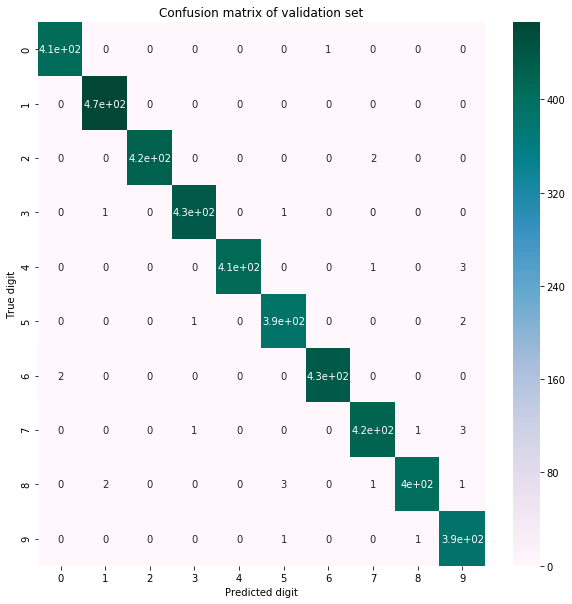

In [41]:
instance = Model_instance_list[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(instance)
y_valid_pred[instance] = nn_graph.forward(sess, x_valid)
sess.close()

cnf_matrix = sklearn.metrics.confusion_matrix(
    one_hot_to_dense(y_valid_pred[instance]), one_hot_to_dense(y_valid)).astype(np.float32)

labels_array = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(1,figsize=(10,10))
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.PuBuGn, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True digit')
plt.xlabel('Predicted digit')
plt.show();

C:\Users\jxp161430\Documents\Jithin\review\Two Sigma\Exploratory Data Analysis\CNN1.meta
INFO:tensorflow:Restoring parameters from CNN1
final train/valid loss = 0.0164/0.0184, train/valid accuracy = 0.9945/0.9933


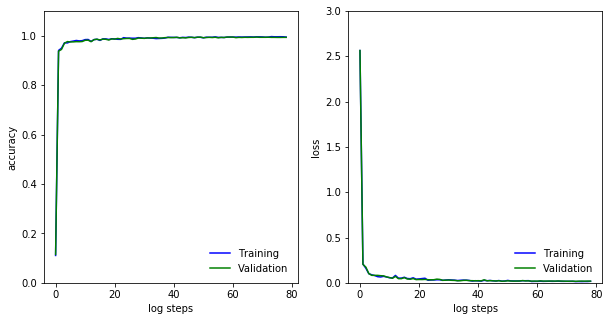

In [42]:
## loss and accuracy curves

nn_graph = nn_class()
sess = nn_graph.load_session_from_file(instance)
train_loss[instance], valid_loss[instance] = nn_graph.get_loss(sess)
train_acc[instance], valid_acc[instance] = nn_graph.get_accuracy(sess)
sess.close()

print('final train/valid loss = %.4f/%.4f, train/valid accuracy = %.4f/%.4f'%(
    train_loss[instance][-1], valid_loss[instance][-1], train_acc[instance][-1], valid_acc[instance][-1]))

plt.figure(figsize=(10, 5));
plt.subplot(1,2,1);
plt.plot(np.arange(0,len(train_acc[instance])), train_acc[instance],'-b', label='Training')
plt.plot(np.arange(0,len(valid_acc[instance])), valid_acc[instance],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.0)
plt.ylabel('accuracy')
plt.xlabel('log steps');

plt.subplot(1,2,2)
plt.plot(np.arange(0,len(train_loss[instance])), train_loss[instance],'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss[instance])), valid_loss[instance],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 3.0, ymin = 0.0)
plt.ylabel('loss')
plt.xlabel('log steps');

C:\Users\jxp161430\Documents\Jithin\review\Two Sigma\Exploratory Data Analysis\CNN1.meta
INFO:tensorflow:Restoring parameters from CNN1
W_conv1: min = -0.40554228 max = 0.30480886 mean = -0.011088983 std = 0.14781868
W_conv2: min = -0.5984618 max = 0.35811886 mean = -0.013514044 std = 0.105048046
W_conv3: min = -0.4627795 max = 0.36970696 mean = -0.016451234 std = 0.106902294


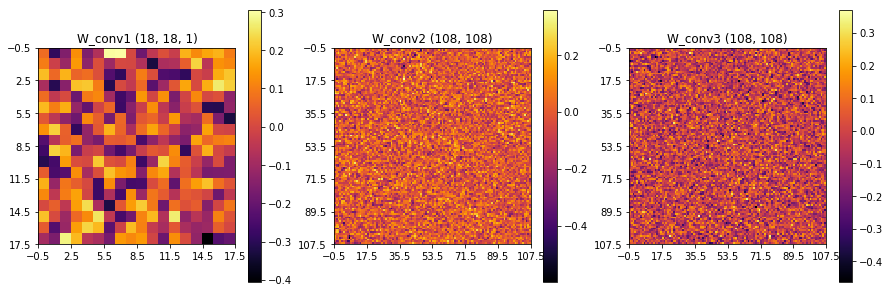

In [56]:
## visualize weights

nn_graph = nn_class()
sess = nn_graph.load_session_from_file(instance)
W_conv1, W_conv2, W_conv3, _, _ = nn_graph.get_weights(sess)
sess.close()

print('W_conv1: min = ' + str(np.min(W_conv1)) + ' max = ' + str(np.max(W_conv1))
      + ' mean = ' + str(np.mean(W_conv1)) + ' std = ' + str(np.std(W_conv1)))
print('W_conv2: min = ' + str(np.min(W_conv2)) + ' max = ' + str(np.max(W_conv2))
      + ' mean = ' + str(np.mean(W_conv2)) + ' std = ' + str(np.std(W_conv2)))
print('W_conv3: min = ' + str(np.min(W_conv3)) + ' max = ' + str(np.max(W_conv3))
      + ' mean = ' + str(np.mean(W_conv3)) + ' std = ' + str(np.std(W_conv3)))

s_f_conv1 = nn_graph.s_f_conv1
s_f_conv2 = nn_graph.s_f_conv2
s_f_conv3 = nn_graph.s_f_conv3

W_conv1 = np.reshape(W_conv1,(s_f_conv1,s_f_conv1,1,6,6))
W_conv1 = np.transpose(W_conv1,(3,0,4,1,2))
W_conv1 = np.reshape(W_conv1,(s_f_conv1*6,s_f_conv1*6,1))

W_conv2 = np.reshape(W_conv2,(s_f_conv2,s_f_conv2,6,6,36))
W_conv2 = np.transpose(W_conv2,(2,0,3,1,4))
W_conv2 = np.reshape(W_conv2,(6*s_f_conv2,6*s_f_conv2,6,6))
W_conv2 = np.transpose(W_conv2,(2,0,3,1))
W_conv2 = np.reshape(W_conv2,(6*6*s_f_conv2,6*6*s_f_conv2))

W_conv3 = np.reshape(W_conv3,(s_f_conv3,s_f_conv3,6,6,36))
W_conv3 = np.transpose(W_conv3,(2,0,3,1,4))
W_conv3 = np.reshape(W_conv3,(6*s_f_conv3,6*s_f_conv3,6,6))
W_conv3 = np.transpose(W_conv3,(2,0,3,1))
W_conv3 = np.reshape(W_conv3,(6*6*s_f_conv3,6*6*s_f_conv3))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.gca().set_xticks(np.arange(-0.5, s_f_conv1*6, s_f_conv1), minor = False);
plt.gca().set_yticks(np.arange(-0.5, s_f_conv1*6, s_f_conv1), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv1 ' + str(W_conv1.shape))
plt.colorbar(plt.imshow(W_conv1[:,:,0], cmap=cm.inferno));

plt.subplot(1,3,2)
plt.gca().set_xticks(np.arange(-0.5, 6*6*s_f_conv2, 6*s_f_conv2), minor = False);
plt.gca().set_yticks(np.arange(-0.5, 6*6*s_f_conv2, 6*s_f_conv2), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv2 ' + str(W_conv2.shape))
plt.colorbar(plt.imshow(W_conv2[:,:], cmap=cm.inferno));

plt.subplot(1,3,3)
plt.gca().set_xticks(np.arange(-0.5, 6*6*s_f_conv3, 6*s_f_conv3), minor = False);
plt.gca().set_yticks(np.arange(-0.5, 6*6*s_f_conv3, 6*s_f_conv3), minor = False);
plt.grid(which = 'minor', color='b', linestyle='-', linewidth=1)
plt.title('W_conv3 ' + str(W_conv3.shape))
plt.colorbar(plt.imshow(W_conv3[:,:], cmap=cm.inferno));

C:\Users\jxp161430\Documents\Jithin\review\Two Sigma\Exploratory Data Analysis\CNN1.meta
INFO:tensorflow:Restoring parameters from CNN1
h_fc2 =  [[-6.41 -1.45 -4.37 -9.91 10.5  -7.01 -3.35 -4.34 -0.6  -1.2 ]]


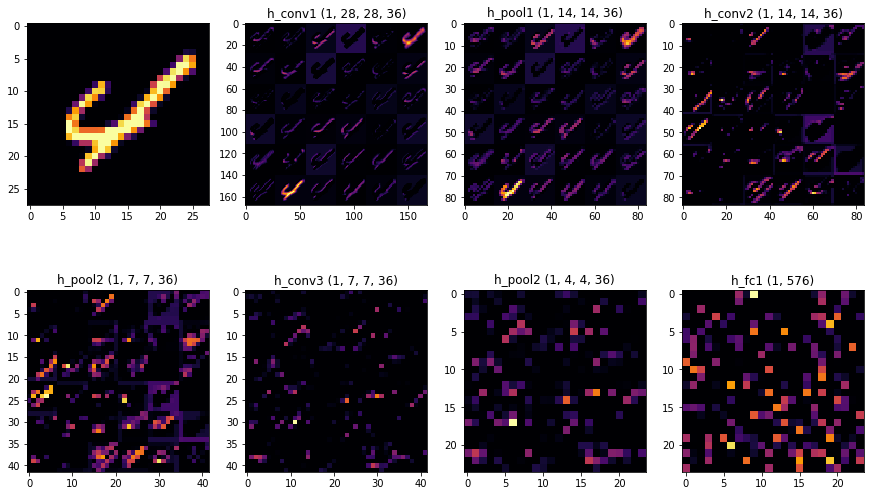

In [55]:
## visualize activations

img_no = 143;
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(instance)
(h_conv1, h_pool1, h_conv2, h_pool2,h_conv3, h_pool3, h_fc1,
 h_fc2) = nn_graph.get_activations(sess, x_train_valid[img_no:img_no+1])
sess.close()
    
# original image
plt.figure(figsize=(15,9))
plt.subplot(2,4,1)
plt.imshow(x_train_valid[img_no].reshape(28,28),cmap=cm.inferno);

# 1. convolution
plt.subplot(2,4,2)
plt.title('h_conv1 ' + str(h_conv1.shape))
h_conv1 = np.reshape(h_conv1,(-1,28,28,6,6))
h_conv1 = np.transpose(h_conv1,(0,3,1,4,2))
h_conv1 = np.reshape(h_conv1,(-1,6*28,6*28))
plt.imshow(h_conv1[0], cmap=cm.inferno);

# 1. max pooling
plt.subplot(2,4,3)
plt.title('h_pool1 ' + str(h_pool1.shape))
h_pool1 = np.reshape(h_pool1,(-1,14,14,6,6))
h_pool1 = np.transpose(h_pool1,(0,3,1,4,2))
h_pool1 = np.reshape(h_pool1,(-1,6*14,6*14))
plt.imshow(h_pool1[0], cmap=cm.inferno);

# 2. convolution
plt.subplot(2,4,4)
plt.title('h_conv2 ' + str(h_conv2.shape))
h_conv2 = np.reshape(h_conv2,(-1,14,14,6,6))
h_conv2 = np.transpose(h_conv2,(0,3,1,4,2))
h_conv2 = np.reshape(h_conv2,(-1,6*14,6*14))
plt.imshow(h_conv2[0], cmap=cm.inferno);

# 2. max pooling
plt.subplot(2,4,5)
plt.title('h_pool2 ' + str(h_pool2.shape))
h_pool2 = np.reshape(h_pool2,(-1,7,7,6,6))
h_pool2 = np.transpose(h_pool2,(0,3,1,4,2))
h_pool2 = np.reshape(h_pool2,(-1,6*7,6*7))
plt.imshow(h_pool2[0], cmap=cm.inferno);

# 3. convolution
plt.subplot(2,4,6)
plt.title('h_conv3 ' + str(h_conv3.shape))
h_conv3 = np.reshape(h_conv3,(-1,7,7,6,6))
h_conv3 = np.transpose(h_conv3,(0,3,1,4,2))
h_conv3 = np.reshape(h_conv3,(-1,6*7,6*7))
plt.imshow(h_conv3[0], cmap=cm.inferno);

# 3. max pooling
plt.subplot(2,4,7)
plt.title('h_pool2 ' + str(h_pool3.shape))
h_pool3 = np.reshape(h_pool3,(-1,4,4,6,6))
h_pool3 = np.transpose(h_pool3,(0,3,1,4,2))
h_pool3 = np.reshape(h_pool3,(-1,6*4,6*4))
plt.imshow(h_pool3[0], cmap=cm.inferno);

# 4. FC layer
plt.subplot(2,4,8)
plt.title('h_fc1 ' + str(h_fc1.shape))
h_fc1 = np.reshape(h_fc1,(-1,24,24))
plt.imshow(h_fc1[0], cmap=cm.inferno);

# 5. FC layer
np.set_printoptions(precision=2)
print('h_fc2 = ', h_fc2)

C:\Users\jxp161430\Documents\Jithin\review\Two Sigma\Exploratory Data Analysis\CNN1.meta
INFO:tensorflow:Restoring parameters from CNN1
# false predictions:  28 out of 4200


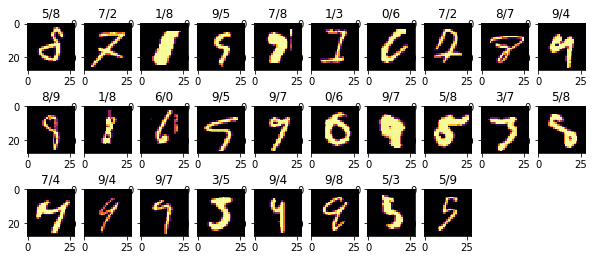

In [54]:
## show misclassified images

nn_graph = nn_class()
sess = nn_graph.load_session_from_file(instance)
y_valid_pred[instance] = nn_graph.forward(sess, x_valid)
sess.close()

y_valid_pred_label = one_hot_to_dense(y_valid_pred[instance])
y_valid_label = one_hot_to_dense(y_valid)
y_val_false_index = []

for i in range(y_valid_label.shape[0]):
    if y_valid_pred_label[i] != y_valid_label[i]:
        y_val_false_index.append(i)

print('# false predictions: ', len(y_val_false_index),'out of', len(y_valid))

plt.figure(figsize=(10,15))
for j in range(0,5):
    for i in range(0,10):
        if j*10+i<len(y_val_false_index):
            plt.subplot(10,10,j*10+i+1)
            plt.title('%d/%d'%(y_valid_label[y_val_false_index[j*10+i]],
                               y_valid_pred_label[y_val_false_index[j*10+i]]))
            plt.imshow(x_valid[y_val_false_index[j*10+i]].reshape(28,28),cmap=cm.inferno)  

In [50]:
nn_graph = nn_class() # create instance
sess = nn_graph.load_session_from_file(instance) # receive session 
y_test_pred = {}
y_test_pred_labels = {}

# split evaluation of test predictions into batches
kfold = sklearn.model_selection.KFold(40, shuffle=False) 
for i,(train_index, valid_index) in enumerate(kfold.split(x_test)):
    if i==0:
        y_test_pred[instance] = nn_graph.forward(sess, x_test[valid_index])
    else: 
        y_test_pred[instance] = np.concatenate([y_test_pred[instance],
                                              nn_graph.forward(sess, x_test[valid_index])])
        
sess.close()

y_test_pred_labels[instance] = one_hot_to_dense(y_test_pred[instance])

print(instance +': y_test_pred_labels[instance].shape = ', y_test_pred_labels[instance].shape)
unique, counts = np.unique(y_test_pred_labels[instance], return_counts=True)
print(dict(zip(unique, counts)))

C:\Users\jxp161430\Documents\Jithin\review\Two Sigma\Exploratory Data Analysis\CNN1.meta
INFO:tensorflow:Restoring parameters from CNN1
CNN1: y_test_pred_labels[instance].shape =  (28000,)
{0: 2763, 1: 3188, 2: 2811, 3: 2816, 4: 2765, 5: 2500, 6: 2749, 7: 2898, 8: 2743, 9: 2767}


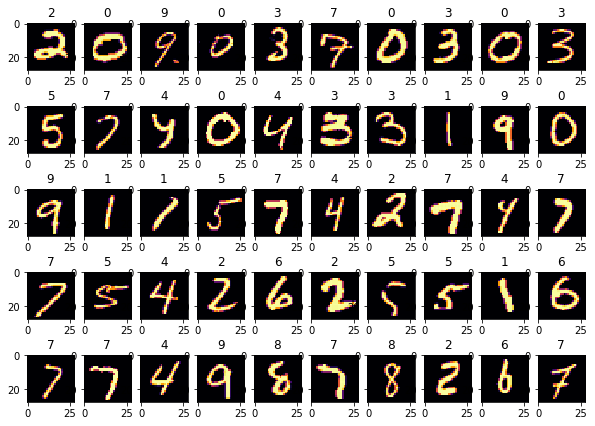

In [53]:
plt.figure(figsize=(10,15))
for j in range(0,5):
    for i in range(0,10):
        plt.subplot(10,10,j*10+i+1)
        plt.title('%d'%y_test_pred_labels[instance][j*10+i])
        plt.imshow(x_test[j*10+i].reshape(28,28), cmap=cm.inferno)

In [ ]:
# Suppose I have 4 models, how would I stack them up
Model_instance_list = ['CNN1', 'CNN2', 'CNN3', 'CNN4']

# cross validations
# choose the same seed as was done for training the neural nets
kfold = sklearn.model_selection.KFold(len(Model_instance_list), shuffle=True, random_state = 123)

# train and test data for meta model
x_train_meta = np.array([]).reshape(-1,10)
y_train_meta = np.array([]).reshape(-1,10)
x_test_meta = np.zeros((x_test.shape[0], 10))

print('Out-of-folds predictions:')

# make out-of-folds predictions from base models
for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):

    # training and validation data
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]

    # load neural network and make predictions
    instance = Model_instance_list[i] 
    nn_graph = nn_class()
    sess = nn_graph.load_session_from_file(instance)
    y_train_pred[instance] = nn_graph.forward(sess, x_train[:len(x_valid)])
    y_valid_pred[instance] = nn_graph.forward(sess, x_valid)
    y_test_pred[instance] = nn_graph.forward(sess, x_test)
    sess.close()

    # collect train and test data for meta model 
    x_train_meta = np.concatenate([x_train_meta, y_valid_pred[instance]])
    y_train_meta = np.concatenate([y_train_meta, y_valid]) 
    x_test_meta += y_test_pred[instance]

    print(take_models[i],': train/valid accuracy = %.4f/%.4f'%(
        accuracy_from_one_hot_labels(y_train_pred[instance], y_train[:len(x_valid)]),
        accuracy_from_one_hot_labels(y_valid_pred[instance], y_valid)))

    if False:
        break;

# take average of test predictions
x_test_meta = x_test_meta/(i+1)
y_test_pred['stacked_models'] = x_test_meta

print('Stacked models: valid accuracy = %.4f'%accuracy_from_one_hot_labels(x_train_meta,
                                                                               y_train_meta))
     